In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Extracted Features Load

In [ ]:
def read_h5_images(h5_file):
    image_arrays = []
    with h5py.File(h5_file, 'r') as hf:
        keys = list(hf.keys())
        num_images = min(200, len(keys))

        for i in range(num_images):
            image_data = hf[keys[i]][()]
            image_arrays.append(image_data)

    return np.array(image_arrays)

syndrome_features = read_h5_images('syndrome_features_200.h5')
non_syndrome_features = read_h5_images('non_syndrome_features_200.h5')

print(syndrome_features.shape)
print(non_syndrome_features.shape)

(200, 3)
(200, 3)


In [ ]:
import numpy as np
import torch

syndrome_features = torch.tensor(np.array(syndrome_features)).float()
print(syndrome_features.shape)

non_syndrome_features = torch.tensor(np.array(non_syndrome_features)).float()
print(non_syndrome_features.shape)

torch.Size([200, 3])
torch.Size([200, 3])


# Extracted Features Visualization

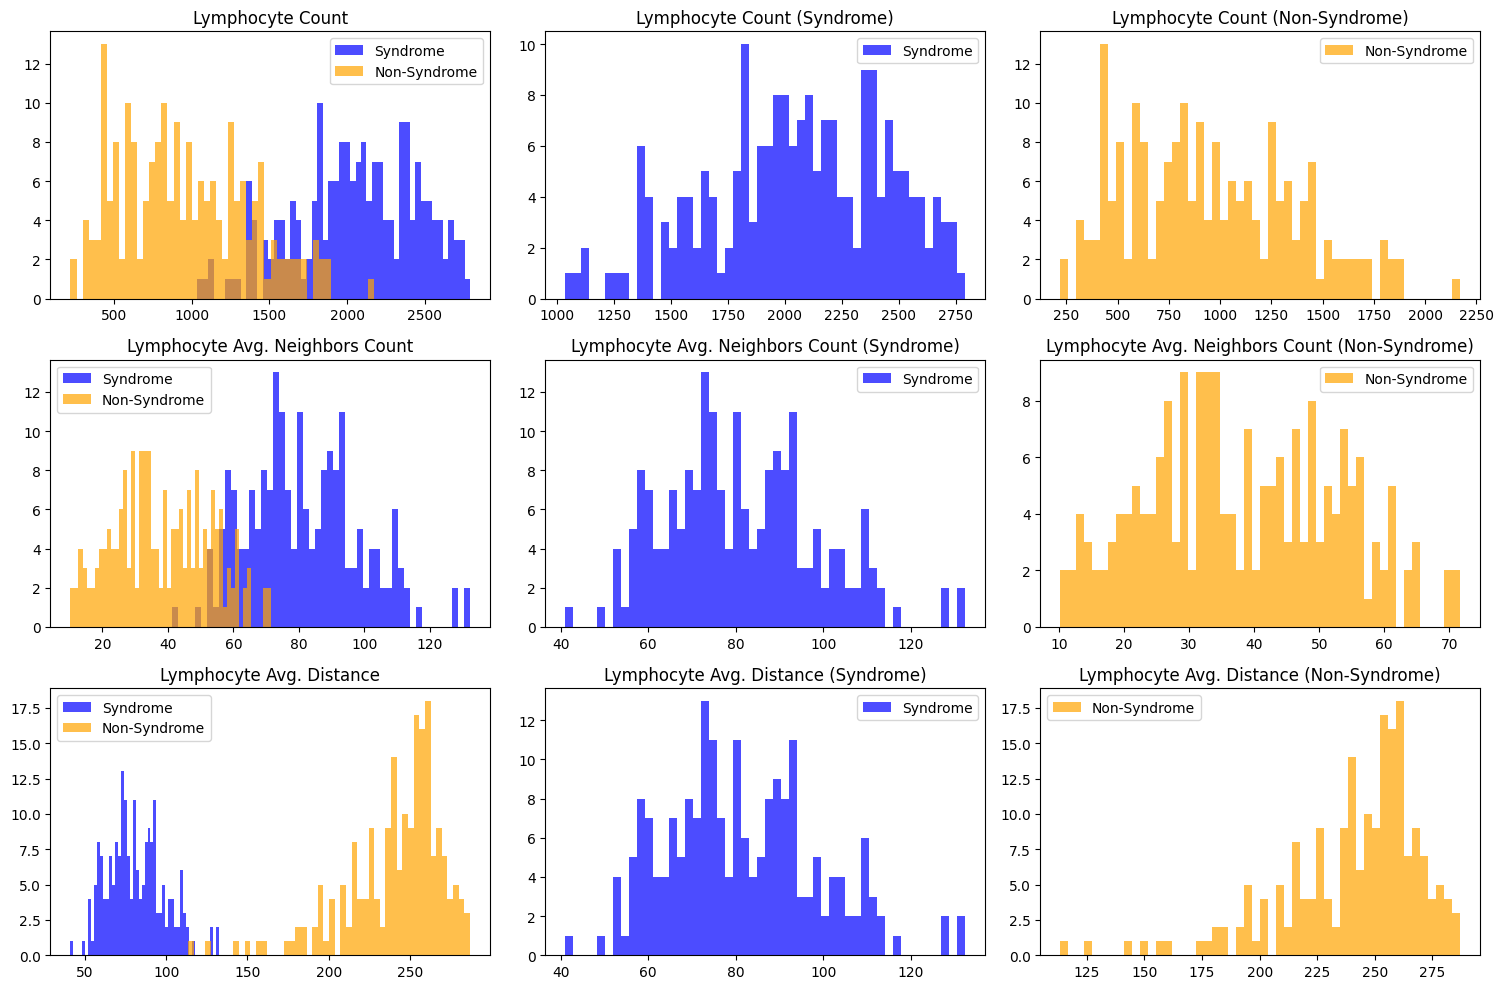

Lymphocyte Count (Syndrome) Mean: 2054.36
Lymphocyte Count (Syndrome) Std: 393.10
Lymphocyte Count (Non-Syndrome) Mean: 956.83
Lymphocyte Count (Non-Syndrome) Std: 411.29
Lymphocyte Avg. Neighbors Count (Syndrome) Mean: 81.45
Lymphocyte Avg. Neighbors Count (Syndrome) Std: 17.20
Lymphocyte Avg. Neighbors Count (Non-Syndrome) Mean: 38.34
Lymphocyte Avg. Neighbors Count (Non-Syndrome) Std: 14.52
Lymphocyte Avg. Distance (Syndrome) Mean: 81.45
Lymphocyte Avg. Distance (Syndrome) Std: 17.20
Lymphocyte Avg. Distance (Non-Syndrome) Mean: 240.75
Lymphocyte Avg. Distance (Non-Syndrome) Std: 29.96


In [ ]:
# Plot connected components features
# Extract the last three columns
dark_points_count_syndrome = syndrome_features[:, 0]
avg_neighbors_count_syndrome = syndrome_features[:, 1]
avg_distance_syndrome = syndrome_features[:, -2]

dark_points_count_non_syndrome = non_syndrome_features[:, 0]
avg_neighbors_count_non_syndrome = non_syndrome_features[:, 1]
avg_distance_non_syndrome = non_syndrome_features[:, 2]

# Create subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

# Plot dark points count
axs[0, 0].hist(dark_points_count_syndrome, bins=50, color='blue', alpha=0.7, label='Syndrome')
axs[0, 0].hist(dark_points_count_non_syndrome, bins=50, color='orange', alpha=0.7, label='Non-Syndrome')
axs[0, 0].set_title('Lymphocyte Count')
axs[0, 0].legend()

# Plot avg neighbors count
axs[1, 0].hist(avg_neighbors_count_syndrome, bins=50, color='blue', alpha=0.7, label='Syndrome')
axs[1, 0].hist(avg_neighbors_count_non_syndrome, bins=50, color='orange', alpha=0.7, label='Non-Syndrome')
axs[1, 0].set_title('Lymphocyte Avg. Neighbors Count')
axs[1, 0].legend()

# Plot avg distance
axs[2, 0].hist(avg_distance_syndrome, bins=50, color='blue', alpha=0.7, label='Syndrome')
axs[2, 0].hist(avg_distance_non_syndrome, bins=50, color='orange', alpha=0.7, label='Non-Syndrome')
axs[2, 0].set_title('Lymphocyte Avg. Distance')
axs[2, 0].legend()

# Add individual histograms for better visibility
axs[0, 1].hist(dark_points_count_syndrome, bins=50, color='blue', alpha=0.7, label='Syndrome')
axs[0, 1].set_title('Lymphocyte Count (Syndrome)')
axs[0, 1].legend()

axs[1, 1].hist(avg_neighbors_count_syndrome, bins=50, color='blue', alpha=0.7, label='Syndrome')
axs[1, 1].set_title('Lymphocyte Avg. Neighbors Count (Syndrome)')
axs[1, 1].legend()

axs[2, 1].hist(avg_distance_syndrome, bins=50, color='blue', alpha=0.7, label='Syndrome')
axs[2, 1].set_title('Lymphocyte Avg. Distance (Syndrome)')
axs[2, 1].legend()

axs[0, 2].hist(dark_points_count_non_syndrome, bins=50, color='orange', alpha=0.7, label='Non-Syndrome')
axs[0, 2].set_title('Lymphocyte Count (Non-Syndrome)')
axs[0, 2].legend()

axs[1, 2].hist(avg_neighbors_count_non_syndrome, bins=50, color='orange', alpha=0.7, label='Non-Syndrome')
axs[1, 2].set_title('Lymphocyte Avg. Neighbors Count (Non-Syndrome)')
axs[1, 2].legend()

axs[2, 2].hist(avg_distance_non_syndrome, bins=50, color='orange', alpha=0.7, label='Non-Syndrome')
axs[2, 2].set_title('Lymphocyte Avg. Distance (Non-Syndrome)')
axs[2, 2].legend()

# Adjust layout
plt.tight_layout()
plt.show()

# Statistics
print(f'Lymphocyte Count (Syndrome) Mean: {np.mean(dark_points_count_syndrome.numpy()):.2f}')
print(f'Lymphocyte Count (Syndrome) Std: {np.std(dark_points_count_syndrome.numpy()):.2f}')
print(f'Lymphocyte Count (Non-Syndrome) Mean: {np.mean(dark_points_count_non_syndrome.numpy()):.2f}')
print(f'Lymphocyte Count (Non-Syndrome) Std: {np.std(dark_points_count_non_syndrome.numpy()):.2f}')
print(f'Lymphocyte Avg. Neighbors Count (Syndrome) Mean: {np.mean(avg_neighbors_count_syndrome.numpy()):.2f}')
print(f'Lymphocyte Avg. Neighbors Count (Syndrome) Std: {np.std(avg_neighbors_count_syndrome.numpy()):.2f}')
print(f'Lymphocyte Avg. Neighbors Count (Non-Syndrome) Mean: {np.mean(avg_neighbors_count_non_syndrome.numpy()):.2f}')
print(f'Lymphocyte Avg. Neighbors Count (Non-Syndrome) Std: {np.std(avg_neighbors_count_non_syndrome.numpy()):.2f}')
print(f'Lymphocyte Avg. Distance (Syndrome) Mean: {np.mean(avg_distance_syndrome.numpy()):.2f}')
print(f'Lymphocyte Avg. Distance (Syndrome) Std: {np.std(avg_distance_syndrome.numpy()):.2f}')
print(f'Lymphocyte Avg. Distance (Non-Syndrome) Mean: {np.mean(avg_distance_non_syndrome.numpy()):.2f}')
print(f'Lymphocyte Avg. Distance (Non-Syndrome) Std: {np.std(avg_distance_non_syndrome.numpy()):.2f}')

# Cross-Validation Training Loop, Training Loop and Evaluation Function

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold

# Function to train the definite model
def train_model(model, dataloader, criterion, optimizer, num_epochs=10, lambda_reg=0.01):
    train_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)

            # Add L2 regularization term to the loss
            l2_regularization = 0.0
            for param in model.parameters():
                l2_regularization += torch.norm(param, p=2)

            loss += lambda_reg * l2_regularization

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(dataloader)
        train_losses.append(epoch_loss)
        #print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    return train_losses

def train_model_with_cross_validation(model, dataset, criterion, optimizer, num_epochs=10, num_folds=5, lambda_reg=0.01):
    train_losses = []
    val_losses = []

    accuracies = []

    # Create KFold cross-validation iterator
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    for fold, (train_indices, val_indices) in enumerate(kf.split(dataset)):
        #print(f"Fold {fold + 1}/{num_folds}")

        # Create data loaders for this fold
        train_subset = torch.utils.data.Subset(dataset, train_indices)
        val_subset = torch.utils.data.Subset(dataset, val_indices)

        train_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
        val_dataloader = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False)

        # Reset the model for each fold
        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

        fold_train_losses = []  # Training losses for this fold
        fold_val_losses = []  # Validation losses for this fold

        fold_accuracies = []

        for epoch in range(num_epochs):
            model.train()
            train_running_loss = 0.0

            for inputs, labels in train_dataloader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)

                # Add L2 regularization term to the loss
                l2_regularization = 0.0
                for param in model.parameters():
                    l2_regularization += torch.norm(param, p=2)

                loss += lambda_reg * l2_regularization

                loss.backward()
                optimizer.step()

                train_running_loss += loss.item()

            train_epoch_loss = train_running_loss / len(train_dataloader)
            fold_train_losses.append(train_epoch_loss)
            #print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_epoch_loss:.4f}')

            model.eval()
            val_running_loss = 0.0

            epoch_labels = []
            epoch_preds = []

            with torch.no_grad():
                for inputs, labels in val_dataloader:
                    outputs = model(inputs)
                    preds = (outputs.squeeze() > 0.5).int()
                    epoch_preds.extend(preds.numpy())
                    epoch_labels.extend(labels.numpy())

                    loss = criterion(outputs.squeeze(), labels)
                    val_running_loss += loss.item()

            epoch_accuracy = accuracy_score(epoch_labels, epoch_preds)

            val_epoch_loss = val_running_loss / len(val_dataloader)
            fold_val_losses.append(val_epoch_loss)

            fold_accuracies.append(epoch_accuracy)

            #print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_epoch_loss:.4f}')

        train_losses.append(fold_train_losses)
        val_losses.append(fold_val_losses)

        accuracies.append(fold_accuracies)

    return train_losses, val_losses, accuracies

# Function to evaluate the model
def evaluate_model(model, dataloader, original_test_data):
    model.eval()
    all_preds, all_labels = [], []

    misclassified_idxs = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            preds = (outputs.squeeze() > 0.5).int()
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())

            # Check if the prediction is incorrect
            for i, (pred, label) in enumerate(zip(preds, labels)):
                if pred != label:
                    misclassified_idxs.append(i)

    misclassified_images = original_test_data[misclassified_idxs]

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, precision, recall, f1, cm, misclassified_images

# MLP Architecture

In [22]:
# Define Multi-Layer Perceptron (MLP)
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return self.sigmoid(x)

# Training Pipeline + Reporting Functions

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from collections import defaultdict

def train_with_multiple_splits(model, num_splits, images, labels, params):

    lr = params[0]
    dropout_rate = params[1]
    lambda_reg = params[2]
    hidden_size = params[3]

    # Lists to store evaluation metrics and loss curves for each split
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    all_train_avg_loss_curves = []
    all_valid_avg_loss_curves = []
    all_avg_accuracies_curves = []
    min_losses = []
    cms = []
    misclassified_images_freqs = defaultdict(int) # won't be used by external function

    # Define a function to train and evaluate the model for one split
    def train_and_evaluate(split_idx, images, labels):
        print(f"Training and evaluating split {split_idx + 1}")

        indices = np.arange(len(images))
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test, _, idxs_test = train_test_split(images, labels, indices, test_size=0.2, random_state=split_idx, stratify=labels)
        original_test_data = images[idxs_test]

        # Standardize the features using PyTorch tensors
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Convert data to PyTorch tensors
        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

        # Create datasets and dataloaders
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

        train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=40, shuffle=False)

        # Instantiate the new MLP model
        input_size = X_train.shape[1]
        output_size = 1
        mlp_model = model(input_size, hidden_size, output_size, dropout_rate)

        # Define loss function and optimizer
        criterion_mlp = nn.BCELoss()
        optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=lr)


        # Train the model
        train_losses_mlp, val_losses_mlp, accuracies_mlp = train_model_with_cross_validation(mlp_model, train_dataset, criterion_mlp, optimizer_mlp, num_epochs=30, num_folds=5, lambda_reg=lambda_reg)
        avg_train_losses = np.mean(train_losses_mlp, axis=0)
        avg_val_losses = np.mean(val_losses_mlp, axis=0)
        avg_accuracies = np.mean(accuracies_mlp, axis=0)

        # Store the loss curve for this split
        all_train_avg_loss_curves.append(avg_train_losses)
        all_valid_avg_loss_curves.append(avg_val_losses)
        all_avg_accuracies_curves.append(avg_accuracies)

        num_epochs = np.argmin(avg_val_losses) + 1
        print('Optimal Epochs:', num_epochs)

        # Definite model: 5 epochs
        mlp_model = model(input_size, hidden_size, output_size, dropout_rate)
        optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=lr)
        train_losses_mlp = train_model(mlp_model, train_dataloader, criterion_mlp, optimizer_mlp, num_epochs=num_epochs, lambda_reg=lambda_reg)

        min_loss = np.min(train_losses_mlp)
        min_losses.append(min_loss)

        # Evaluate the model
        accuracy, precision, recall, f1, cm, misclassified_images = evaluate_model(mlp_model, test_dataloader, original_test_data)
        for image_id in misclassified_images:
            misclassified_images_freqs[str(image_id)] += 1

        cms.append(cm)

        # Store evaluation metrics for this split
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    # Flatten the features
    images_flat = images.reshape(images.shape[0], -1)

    # Run the training and evaluation loop for multiple splits
    for split_idx in range(num_splits):
        train_and_evaluate(split_idx, images_flat, labels)

    avg_train_loss_curve = np.mean(all_train_avg_loss_curves, axis=0)
    avg_valid_loss_curve = np.mean(all_valid_avg_loss_curves, axis=0)
    avg_accuracy_curve = np.mean(all_avg_accuracies_curves, axis=0)

    return accuracy_list, precision_list, recall_list, f1_list, min_losses, cms, avg_train_loss_curve, avg_valid_loss_curve, avg_accuracy_curve


def report(accuracy_list, precision_list, recall_list, f1_list, min_losses, cms, num_splits):

    # Calculate and print average metrics
    avg_accuracy = sum(accuracy_list) / len(accuracy_list)
    avg_precision = sum(precision_list) / len(precision_list)
    avg_recall = sum(recall_list) / len(recall_list)
    avg_f1 = sum(f1_list) / len(f1_list)
    avg_min_loss = sum(min_losses) / len(min_losses)
    avg_cm = sum(cms) / num_splits

    std_accuracy = np.std(np.array(accuracy_list))
    std_precision = np.std(np.array(precision_list))
    std_recall = np.std(np.array(recall_list))
    std_f1 = np.std(np.array(f1_list))
    std_min_loss = np.std(np.array(min_losses))
    std_cm = np.array([[np.std([cm[0, 0] for cm in cms]), np.std([cm[0, 1] for cm in cms])],
                    [np.std([cm[1, 0] for cm in cms]), np.std([cm[1, 1] for cm in cms])]])

    best_idx = np.argmax(np.array(f1_list))

    best_accuracy = accuracy_list[best_idx]
    best_precision = precision_list[best_idx]
    best_recall = recall_list[best_idx]
    best_f1 = f1_list[best_idx]
    best_min_loss = min_losses[best_idx]
    best_cm = cms[best_idx]

    print()
    print(f'Average Accuracy: {avg_accuracy:.8f}')
    print(f'Average Precision: {avg_precision:.8f}')
    print(f'Average Recall: {avg_recall:.8f}')
    print(f'Average F1 Score: {avg_f1:.8f}')
    print(f'Average Min Avg Loss: {avg_min_loss:.8f}')
    print(f'Average Confusion Matrix: {avg_cm}')
    print()

    print(f'Std Accuracy: {std_accuracy:.8f}')
    print(f'Std Precision: {std_precision:.8f}')
    print(f'Std Recall: {std_recall:.8f}')
    print(f'Std F1 Score: {std_f1:.8f}')
    print(f'Std Min Avg Train Loss: {std_min_loss:.8f}')
    print(f'Std Confusion Matrix: {std_cm}')
    print()

    return avg_cm

def plot_multiple_splits_loss_curve(avg_train_loss_curve, avg_valid_loss_curve, title):

    # Set up the figure and axis
    plt.figure(figsize=(10, 6))

    # Plot loss curves for each model
    plt.plot(avg_train_loss_curve, label='Average Training Loss', marker='o', color='mediumblue', linestyle='-')
    plt.plot(avg_valid_loss_curve, label='Average Validation Loss', marker='o', color='crimson', linestyle='-')

    # Set labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title(f'{title} - Cross-Validation Loss Curves')

    # Add legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

def plot_multiple_splits_accuracy_curve(avg_accuracy_curve, title):

    # Set up the figure and axis
    plt.figure(figsize=(10, 6))

    # Plot loss curves for each model
    plt.plot(avg_accuracy_curve, label='Average Validation Accuracy', marker='o', color='mediumturquoise', linestyle='-')

    # Set labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Average Accuracy')
    plt.title(f'{title} - Cross-Validation Accuracy Curve')

    # Add legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

def plot_multiple_splits_cms(avg_cm, title):

    # Plot Confusion Matrix
    plt.imshow(avg_cm, interpolation='nearest', cmap=plt.cm.RdPu)
    plt.title(f'{title} - Confusion Matrix (Test Dataset)')
    plt.colorbar()
    plt.xticks([0, 1], ['Non-Syndrome', 'Syndrome'])
    plt.yticks([0, 1], ['Non-Syndrome', 'Syndrome'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def plot_accuracy_curves(accuracy_curves, title):

    # Set up the figure and axis
    plt.figure(figsize=(10, 6))

    # Plot loss curves for each model
    plt.plot(accuracy_curves[0], label='CNN', marker='o', color='dodgerblue', linestyle='-')
    plt.plot(accuracy_curves[1], label='QNN', marker='o', color='mediumvioletred', linestyle='-')

    # Set labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Validation Accuracy Curves')

    # Add legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

def plot_loss_curves(loss_curves, title):

    # Set up the figure and axis
    plt.figure(figsize=(10, 6))

    # Plot loss curves for each model
    plt.plot(loss_curves[0], label='CNN', marker='o', color='dodgerblue', linestyle='-')
    plt.plot(loss_curves[1], label='QNN', marker='o', color='mediumvioletred', linestyle='-')

    # Set labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title} - Validation Loss Curves')

    # Add legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

# Dataset Preparation

In [26]:
import tensorflow as tf

syndrome_labels = np.ones(len(syndrome_features))
non_syndrome_labels = np.zeros(len(non_syndrome_features))

images = np.concatenate((syndrome_features, non_syndrome_features), axis=0)
labels = np.concatenate((syndrome_labels, non_syndrome_labels), axis=0)

# Grid Search

In [29]:
from itertools import product

num_splits = 5

# Define the hyperparameter grid
learning_rates = [0.005, 0.001]
dropout_rates = [0.3, 0.5]
lambda_reg_values = [0.001, 0.01]
hidden_sizes = [32, 64, 128]

# Create all possible combinations of hyperparameters
hyperparameter_combinations = list(product(learning_rates, dropout_rates, lambda_reg_values, hidden_sizes))

# Perform grid search
best_f1_score = 0.0
best_params = None

for i, params in enumerate(hyperparameter_combinations):
    print(f'{i+1}/{len(hyperparameter_combinations)}')
    print(params)
    _, _, _, f1_list, _, _, _, _, _ = train_with_multiple_splits(MLP, num_splits, images, labels, list(params))

    # Calculate average F1 score across all splits
    avg_f1_score = sum(f1_list) / num_splits

    print(avg_f1_score)
    print()

    # Update best hyperparameters if the current combination performs better
    if avg_f1_score > best_f1_score:
        best_f1_score = avg_f1_score
        best_params = params

print("Best Hyperparameters:", best_params)
print("Best F1 Score:", best_f1_score)

1/24
(0.005, 0.3, 0.001, 32)
Training and evaluating split 1
Optimal Epochs: 10
Training and evaluating split 2
Optimal Epochs: 16
Training and evaluating split 3
Optimal Epochs: 9
Training and evaluating split 4
Optimal Epochs: 30
Training and evaluating split 5
Optimal Epochs: 19
0.9279533062634661

2/24
(0.005, 0.3, 0.001, 64)
Training and evaluating split 1
Optimal Epochs: 5
Training and evaluating split 2
Optimal Epochs: 11
Training and evaluating split 3
Optimal Epochs: 9
Training and evaluating split 4
Optimal Epochs: 28
Training and evaluating split 5
Optimal Epochs: 17
0.9214131246651572

3/24
(0.005, 0.3, 0.001, 128)
Training and evaluating split 1
Optimal Epochs: 4
Training and evaluating split 2
Optimal Epochs: 6
Training and evaluating split 3
Optimal Epochs: 6
Training and evaluating split 4
Optimal Epochs: 11
Training and evaluating split 5
Optimal Epochs: 7
0.9212842404113264

4/24
(0.005, 0.3, 0.01, 32)
Training and evaluating split 1
Optimal Epochs: 9
Training and eva

# Training and Evaluation

Training and evaluating split 1
Optimal Epochs: 13
Training and evaluating split 2
Optimal Epochs: 18
Training and evaluating split 3
Optimal Epochs: 16
Training and evaluating split 4
Optimal Epochs: 30
Training and evaluating split 5
Optimal Epochs: 30
Training and evaluating split 6
Optimal Epochs: 30
Training and evaluating split 7
Optimal Epochs: 21
Training and evaluating split 8
Optimal Epochs: 14
Training and evaluating split 9
Optimal Epochs: 21
Training and evaluating split 10
Optimal Epochs: 23

Average Accuracy: 0.91875000
Average Precision: 0.91710856
Average Recall: 0.92250000
Average F1 Score: 0.91901865
Average Min Avg Loss: 0.23045897
Average Confusion Matrix: [[36.6  3.4]
 [ 3.1 36.9]]

Std Accuracy: 0.02321772
Std Precision: 0.03533854
Std Recall: 0.03614208
Std F1 Score: 0.02318275
Std Min Avg Train Loss: 0.00837727
Std Confusion Matrix: [[1.49666295 1.49666295]
 [1.44568323 1.44568323]]



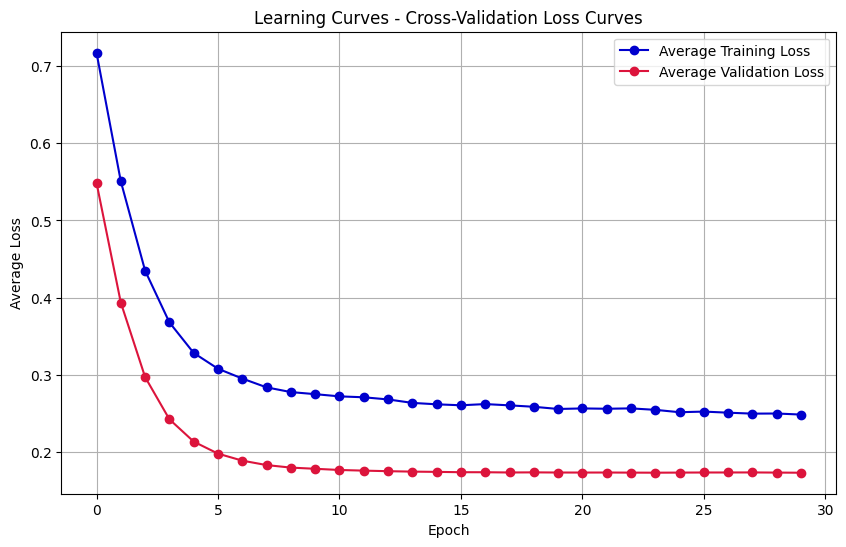

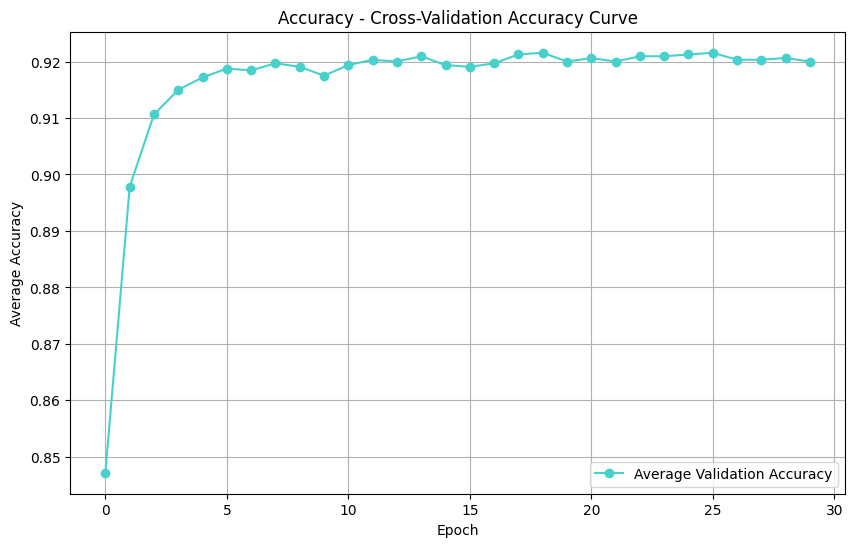

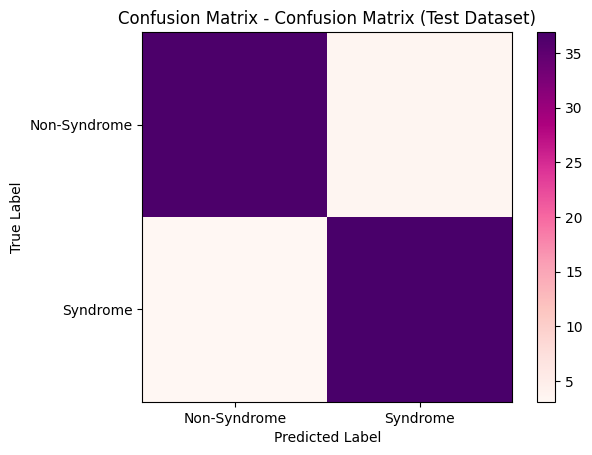

In [30]:
num_splits = 10

params = best_params

accuracy_list, precision_list, recall_list, f1_list, min_losses, cms, avg_train_loss_curve, avg_valid_loss_curve, avg_accuracy_curve = train_with_multiple_splits(MLP, num_splits, images, labels, params)

avg_cm = report(accuracy_list, precision_list, recall_list, f1_list, min_losses, cms, num_splits)

plot_multiple_splits_loss_curve(avg_train_loss_curve, avg_valid_loss_curve, title='Learning Curves')

plot_multiple_splits_accuracy_curve(avg_accuracy_curve, title='Accuracy')

plot_multiple_splits_cms(avg_cm, title='Confusion Matrix')
